# Import Libraries

In [1]:
import os, torch, copy, cv2, sys, random
# from datetime import datetime, timezone, timedelta
import wandb

from PIL import Image
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms

import torchvision.models as models


import albumentations as A
from albumentations.pytorch import ToTensorV2

# Set Arguments & hyperparameters

In [2]:
RANDOM_SEED = 2022

torch.manual_seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

In [3]:
DATA_DIR = '../data'
NUM_CLS = 2

os.environ['CUDA_VISIBLE_DEVICES'] = "0"

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'현재 DEVICE : {DEVICE}')

현재 DEVICE : cuda


# Dataloader

In [4]:
# class CustomDataset(Dataset):
#     def __init__(self, data_dir, mode, aug, train_size=0.9):
#         self.data_dir = data_dir
#         self.mode = mode
#         self.aug = aug
#         self.trina_size = train_size
        
        
#         self.db = self.data_loader()
        
#         if self.mode == 'train':
#             train_index = int(len(self.db) * train_size)
#             self.db = self.db[:train_index]
#         elif self.mode =='val':
#             train_index = int(len(self.db) * train_size)
#             self.db = self.db[train_index:]
#             self.db.reset_index(inplace=True)
#         else:
#             print(f'change mode! train or val')
        
        
#     def data_loader(self):
#         print('Loading ' + self.mode + ' dataset..')
#         # 경로 존재하지 않을 경우 error
#         if not os.path.isdir(self.data_dir):
#             print(f'!!! Cannot find {self.data_dir}... !!!')
#             sys.exit()
            
#         db = pd.read_csv(os.path.join(self.data_dir, 'train.csv'))
        
#         return db
    
#     def __len__(self):
#         return len(self.db)
    
#     def __getitem__(self, index):
#         data = copy.deepcopy(self.db.loc[index])
        
#         data_dir/train/001.png
#         img = cv2.imread(os.path.join(self.data_dir, 'train', data['file_name']))
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
#         if not isinstance(img, np.ndarray):
#             raise IOError("Fail to read %s" % data['file_name'])
        

#         trans_image = self.aug(image=img)["image"]
        
        
#         # return img, label
#         return trans_image, data['COVID']
        
        

In [5]:
class CustomDataset(Dataset):
    def __init__(self, data_dir, mode, input_shape, transform):
        self.data_dir = data_dir
        self.mode = mode
        self.transform = transform
        self.input_shape = input_shape
        
        # Loading dataset
        self.db = self.data_loader()
        
        # Dataset split
        if self.mode == 'train':
            self.db = self.db[:int(len(self.db) * 0.9)]
        elif self.mode == 'val':
            self.db = self.db[int(len(self.db) * 0.9):]
            self.db.reset_index(inplace=True)
        else:
            print(f'!!! Invalid split {self.mode}... !!!')
            
        # Transform function
        self.transform = transform

    def data_loader(self):
        print('Loading ' + self.mode + ' dataset..')
        if not os.path.isdir(self.data_dir):
            print(f'!!! Cannot find {self.data_dir}... !!!')
            sys.exit()
        
        # (COVID : 1, No : 0)
        db = pd.read_csv(os.path.join(self.data_dir, 'train.csv'))
        
        return db

    def __len__(self):
        return len(self.db)

    def __getitem__(self, index):
        data = copy.deepcopy(self.db.loc[index])

        # Loading image
        cvimg = cv2.imread(os.path.join(self.data_dir,'train',data['file_name']), cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
        cvimg = np.invert(cvimg)
        if not isinstance(cvimg, np.ndarray):
            raise IOError("Fail to read %s" % data['file_name'])

        # Preprocessing images
        trans_image = self.transform(Image.fromarray(cvimg))
        

        return trans_image, data['COVID']


# Utils

In [6]:
class LossEarlyStopper():
    """Early stopper
    
    Attributes:
        patience (int): loss가 줄어들지 않아도 학습할 epoch 수
        patience_counter (int): loss 가 줄어들지 않을 때 마다 1씩 증가, 감소 시 0으로 리셋
        min_loss (float): 최소 loss
        stop (bool): True 일 때 학습 중단
    """

    def __init__(self, patience: int)-> None:
        self.patience = patience

        self.patience_counter = 0
        self.min_loss = np.Inf
        self.stop = False
        self.save_model = False

    def check_early_stopping(self, loss: float)-> None:
        """Early stopping 여부 판단"""  

        if self.min_loss == np.Inf:
            self.min_loss = loss
            return None

        elif loss > self.min_loss:
            self.patience_counter += 1
            msg = f"Early stopping counter {self.patience_counter}/{self.patience}"

            if self.patience_counter == self.patience:
                self.stop = True
                
        elif loss <= self.min_loss:
            self.patience_counter = 0
            self.save_model = True
            msg = f"Validation loss decreased {self.min_loss} -> {loss}"
            self.min_loss = loss
        
        print(msg)
    

class Trainer():
    def __init__(self, loss_fn, model, device, metric_fn, optimizer=None, scheduler=None):
        self.loss_fn = loss_fn
        self.model = model
        self.device = device
        self.metric_fn = metric_fn
        self.optimizer = optimizer
        self.scheduler = scheduler
        
    def train_epoch(self, dataloader, epoch_index):

        # train mode
        self.model.train()
        
        train_total_loss = 0
        target_lst = []
        pred_lst = []
        prob_lst = []

        for batch_index, (img, label) in enumerate(dataloader):
            img = img.to(self.device)
            label = label.to(self.device).float()
            
            # predict
            pred = self.model(img)
            
            # loss
            loss = loss_fn(pred[:, 1], label)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            self.scheduler.step()
            
            train_total_loss += loss.item()
            
            prob_lst.extend(pred[:, 1].cpu().tolist())
            target_lst.extend(label.cpu().tolist())
            pred_lst.extend(pred.argmax(dim=1).cpu().tolist())
            
        self.train_mean_loss = train_total_loss / batch_index
        self.train_score, f1 = self.metric_fn(y_pred=pred_lst, y_answer=target_lst)
        
        # epoch msg
        print(f'Epoch {epoch_index}, Train loss: {self.train_mean_loss:.4f}, Acc: {self.train_score:.4f}, F1-Macro: {f1:.4f}')
        
    def validate_epoch(self, dataloader, epoch_index):
        self.model.eval()
        val_total_loss = 0
        target_lst = []
        pred_lst = []
        prob_lst = []
    
        
        for batch_index, (img, label) in enumerate(dataloader):
            img = img.to(self.device)
            label = label.to(self.device).float()

            pred = self.model(img)
            
            loss = self.loss_fn(pred[:, 1], label)
            val_total_loss += loss.item()
            
            prob_lst.extend(pred[:, 1].cpu().tolist())
            pred_lst.extend(pred.argmax(dim=1).cpu().tolist())
            target_lst.extend(label.cpu().tolist())
        
        self.val_mean_loss = val_total_loss / batch_index
        self.validation_score, f1 = self.metric_fn(y_pred=pred_lst, y_answer=target_lst)
        print(f'Epoch {epoch_index}, Val loss: {self.val_mean_loss:.4f}, Acc: {self.validation_score:.4f}, F1-Macro: {f1:.4f}')        

In [7]:
from sklearn.metrics import accuracy_score, f1_score

def get_metric_fn(y_pred, y_answer):
    """ 성능을 반환하는 함수"""
    
    assert len(y_pred) == len(y_answer), 'The size of prediction and answer are not same.'
    accuracy = accuracy_score(y_answer, y_pred)
    f1 = f1_score(y_answer, y_pred, average='macro')
    return accuracy, f1

# Model

### efficientnet

In [8]:
from efficientnet_pytorch import EfficientNet

class EfficientNetb0(nn.Module):
    def __init__(self, num_classes):
        super(EfficientNetb0, self).__init__()
        self.model = EfficientNet.from_name('efficientnet-b0', num_classes=num_classes)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.model(x)
        output = self.softmax(x)
        
        return output
    
class EfficientNetb1(nn.Module):
    def __init__(self, num_classes):
        super(EfficientNetb1, self).__init__()
        self.model = EfficientNet.from_name('efficientnet-b1', num_classes=num_classes)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.model(x)
        output = self.softmax(x)
        
        return output


### Resnet

In [9]:
class Resnet18(nn.Module):
    def __init__(self, num_classes):
        super(Resnet18, self).__init__()
        self.model = models.resnet18(pretrained=False)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.model(x)
        output = self.softmax(x)
        
        return output
    
class Resnet34(nn.Module):
    def __init__(self, num_classes):
        super(Resnet34, self).__init__()
        self.model = models.resnet34(pretrained=False)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.model(x)
        output = self.softmax(x)
        
        return output

class Resnet50(nn.Module):
    def __init__(self, num_classes):
        super(Resnet50, self).__init__()
        self.model = models.resnet50(pretrained=False)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.model(x)
        output = self.softmax(x)
        
        return output

### VGG

In [10]:
class VGG11_bn(nn.Module):
    def __init__(self, num_classes):
        super(VGG11_bn, self).__init__()
        self.model = models.vgg11_bn(pretrained=False)
        self.model.classifier[6] = nn.Linear(self.model.classifier[6].in_features, num_classes)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.model(x)
        output = self.softmax(x)
        
        return output

class VGG13_bn(nn.Module):
    def __init__(self, num_classes):
        super(VGG13_bn, self).__init__()
        self.model = models.vgg13_bn(pretrained=False)
        self.model.classifier[6] = nn.Linear(self.model.classifier[6].in_features, num_classes)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.model(x)
        output = self.softmax(x)
        
        return output
    
class VGG13(nn.Module):
    def __init__(self, num_classes):
        super(VGG13, self).__init__()
        self.model = models.vgg13(pretrained=False)
        self.model.classifier[6] = nn.Linear(self.model.classifier[6].in_features, num_classes)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.model(x)
        output = self.softmax(x)
        
        return output
    
    
class VGG16_bn(nn.Module):
    def __init__(self, num_classes):
        super(VGG16_bn, self).__init__()
        self.model = models.vgg16_bn(pretrained=False)
        self.model.classifier[6] = nn.Linear(self.model.classifier[6].in_features, num_classes)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.model(x)
        output = self.softmax(x)
        
        return output

### GoogleNet

In [11]:
class Googlenet(nn.Module):
    def __init__(self, num_classes):
        super(Googlenet, self).__init__()
        self.model = models.googlenet(pretrained=False)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.model(x)
        if isinstance(x, torch.Tensor):
            output = self.softmax(x)
        else:
            output = self.softmax(x.logits)
        
        return output

### Inception

In [12]:
class Inception_v3(nn.Module):
    def __init__(self, num_classes):
        super(Inception_v3, self).__init__()
        self.model = models.inception_v3(aux_logits=False, pretrained=False)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.model(x)
        output = self.softmax(x)
        
        return output

In [13]:
# model = Resnet18_no_pretrained(2).to(DEVICE)

In [14]:
# model = Googlenet(2).to(DEVICE)
# a = torch.rand((1, 3, 128, 128))
# output = model(a.to(DEVICE))
# print(output)

# select model

In [15]:
model = VGG13_bn(2).to(DEVICE)

# augmentation

In [26]:
# class CustomDataset2(Dataset):
#     def __init__(self, data_dir, mode, input_shape):
#         self.data_dir = data_dir
#         self.mode = mode
#         self.input_shape = input_shape
        
#         # Loading dataset
#         self.db = self.data_loader()
        
#         # Dataset split
#         if self.mode == 'train':
#             self.db = self.db[:int(len(self.db) * 0.9)]
#         elif self.mode == 'val':
#             self.db = self.db[int(len(self.db) * 0.9):]
#             self.db.reset_index(inplace=True)
#         else:
#             print(f'!!! Invalid split {self.mode}... !!!')
            
#         # Transform function
#         self.transform = transforms.Compose([transforms.Resize(self.input_shape),
#                                              transforms.ToTensor()])

#     def data_loader(self):
#         print('Loading ' + self.mode + ' dataset..')
#         if not os.path.isdir(self.data_dir):
#             print(f'!!! Cannot find {self.data_dir}... !!!')
#             sys.exit()
        
#         # (COVID : 1, No : 0)
#         db = pd.read_csv(os.path.join(self.data_dir, 'train.csv'))
        
#         return db

#     def __len__(self):
#         return len(self.db)

#     def __getitem__(self, index):
#         data = copy.deepcopy(self.db.loc[index])

#         # Loading image
#         cvimg = cv2.imread(os.path.join(self.data_dir,'train',data['file_name']), cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
#         if not isinstance(cvimg, np.ndarray):
#             raise IOError("Fail to read %s" % data['file_name'])

#         # Preprocessing images
#         trans_image = self.transform(Image.fromarray(cvimg))

#         return trans_image, data['COVID']


# INPUT_SHAPE=338
# train_dataset = CustomDataset2(data_dir=DATA_DIR, mode='train', input_shape=INPUT_SHAPE)
# train_dataset = DataLoader(train_dataset, shuffle=True)

# def get_mean_std(dataset):
#     img = [np.asarray(image) for image, _ in train_dataset]
#     img = np.array(img)
    
#     meanR = np.mean(img[:, :, 2, :, :])
#     meanG = np.mean(img[:, :, 1, :, :])
#     meanB = np.mean(img[:, :, 0, :, :])
    
#     stdR = np.std(img[:, :, 2, :, :])
#     stdG = np.std(img[:, :, 1, :, :])
#     stdB = np.std(img[:, :, 0, :, :])
    
#     return (meanR, meanG, meanR), (stdB, stdG, stdR)

# get_mean_std(train_dataset)

In [27]:
# INPUT_SHAPE = 256
# BATCH_SIZE = 24

# mean = (0.59760803, 0.59713995, 0.59760803)
# std = (0.32656872, 0.32661003, 0.32659915)

# original = A.Compose([
#             A.Resize(INPUT_SHAPE, INPUT_SHAPE),
#             A.Normalize(mean=mean, std=std),
#             ToTensorV2()
#         ])


# aug1 = A.Compose([
#             A.Resize(INPUT_SHAPE, INPUT_SHAPE),
#             A.Normalize(mean=mean, std=std),
#             A.VerticalFlip(p=0.5),
#             A.HorizontalFlip(p=0.5),
#             A.Rotate(limit=30, p=1),
#             ToTensorV2()
#         ])

# aug1_1 = A.Compose([
#             A.Resize(INPUT_SHAPE, INPUT_SHAPE),
#             A.Normalize(mean=mean, std=std),
#             A.VerticalFlip(p=0.3),
#             A.HorizontalFlip(p=0.3),
#             A.Rotate(limit=50, p=1),
#             ToTensorV2()
#         ])


# aug2 = A.Compose([
#             A.Resize(INPUT_SHAPE, INPUT_SHAPE),
#             A.Normalize(mean=mean, std=std),
#             A.ShiftScaleRotate(p=0.5), 
#             A.Transpose(p=1),
#             ToTensorV2()
#         ])


# aug_transform = A.Compose([
#             A.Resize(INPUT_SHAPE, INPUT_SHAPE),
#             A.Normalize(mean=mean, std=std),
#             A.GridDistortion(num_steps=5, p=0.5),
#             A.Rotate(limit=30, p=0.5),
#             A.VerticalFlip(p=0.5),
#             A.HorizontalFlip(p=0.5),

#             ToTensorV2()
# ])

In [28]:
# original_train = CustomDataset(data_dir=DATA_DIR, aug=transform,  mode='train')
# # original_train1 = CustomDataset(data_dir=DATA_DIR, aug=aug1,  mode='train')
# # original_train2 = CustomDataset(data_dir=DATA_DIR, aug=aug1_1,  mode='train')
# # original_train3 = CustomDataset(data_dir=DATA_DIR, aug=aug2,  mode='train')
# # original_train4 = CustomDataset(data_dir=DATA_DIR, aug=aug2,  mode='train')

# original_valid = CustomDataset(data_dir=DATA_DIR, aug=transform,  mode='val')
# # original_valid1 = CustomDataset(data_dir=DATA_DIR, aug=aug1,  mode='val')
# # original_valid2 = CustomDataset(data_dir=DATA_DIR, aug=aug1_1,  mode='val')
# # original_valid3 = CustomDataset(data_dir=DATA_DIR, aug=aug2,  mode='val')
# # original_valid4 = CustomDataset(data_dir=DATA_DIR, aug=aug2,  mode='val')


# train_dataset = torch.utils.data.ConcatDataset([original_train])
# valid_dataset = torch.utils.data.ConcatDataset([original_valid])

# print(f'train : {len(train_dataset)}, valid : {len(valid_dataset)}')

# # print(len(train_dataset), len(valid_dataset))
# train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
# valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [16]:
INPUT_SHAPE=256
BATCH_SIZE = 32

mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

original = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(INPUT_SHAPE),
    transforms.Normalize(mean, std),  
    transforms.Grayscale(num_output_channels=3)
])

original2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(INPUT_SHAPE),
    transforms.Normalize(mean, std),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=(0, 180)),
    transforms.Grayscale(num_output_channels=3)
])

original3 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomRotation(degrees=(0, 180)),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.CenterCrop(size=245),
    transforms.Resize(INPUT_SHAPE)
    
])


In [17]:
# Load dataset & dataloader
original_train = CustomDataset(data_dir=DATA_DIR, mode='train', input_shape=INPUT_SHAPE, transform=original)
original_valid = CustomDataset(data_dir=DATA_DIR, mode='val', input_shape=INPUT_SHAPE, transform=original)

original_train2 = CustomDataset(data_dir=DATA_DIR, mode='train', input_shape=INPUT_SHAPE, transform=original2)
original_valid2 = CustomDataset(data_dir=DATA_DIR, mode='val', input_shape=INPUT_SHAPE, transform=original2)

# original_train3 = CustomDataset(data_dir=DATA_DIR, mode='train', input_shape=INPUT_SHAPE, transform=original3)
# original_valid3 = CustomDataset(data_dir=DATA_DIR, mode='val', input_shape=INPUT_SHAPE, transform=original3)


train_dataset = torch.utils.data.ConcatDataset([original_train, original_train2])
valid_dataset = torch.utils.data.ConcatDataset([original_valid])


train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)
print('Train set samples:',len(train_dataset),  'Val set samples:', len(valid_dataset))

Loading train dataset..
Loading val dataset..
Loading train dataset..
Loading val dataset..
Train set samples: 1162 Val set samples: 65


## 이미지 확인

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


img scale min: -2.033712387084961 max: 2.3987302780151367


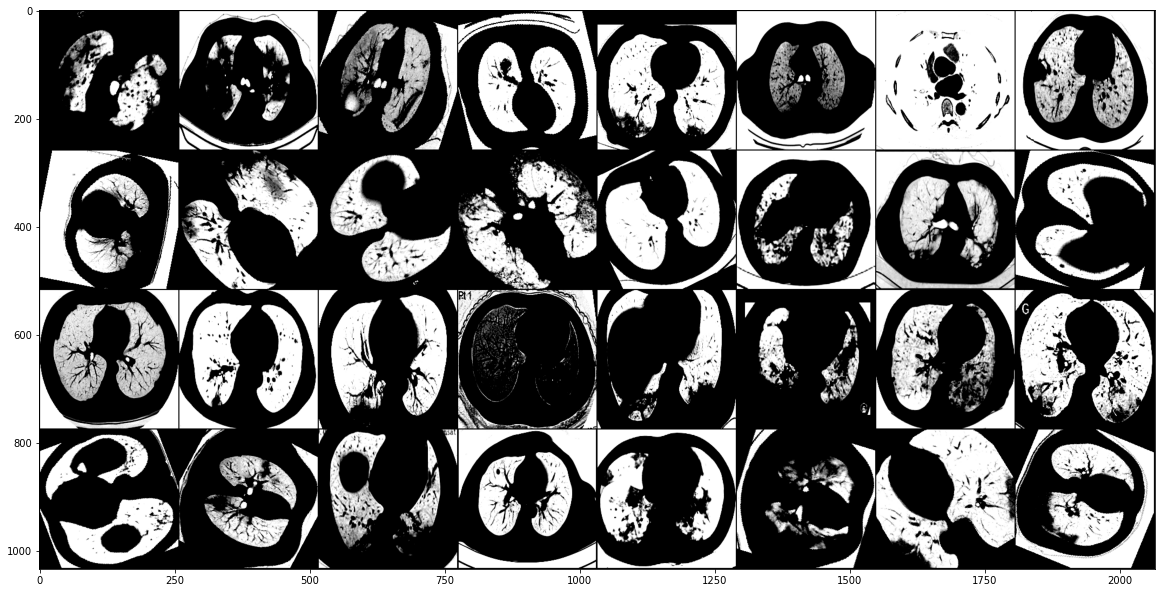

In [18]:
import matplotlib.pyplot as plt
import torchvision

check = A.Compose([
    A.ToGray(p=1)
])

plt.figure(figsize=(20, 15))

def imshow_check(img):
    print(f'img scale min: {img.min()} max: {img.max()}')
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

    plt.close()
    

# get some random training images
dataiter = iter(train_dataloader)
images, labels = dataiter.next()

# show images
imshow_check(torchvision.utils.make_grid(images))

# Train

In [19]:
EPOCHS = 50
LEARNING_RATE = 0.0003
EARLY_STOPPING_PATIENCE = 20

# Load Model
# model = custom_CNN(NUM_CLS).to(DEVICE)
# model = Resnet34_no_pretrained(2).to(DEVICE)

# # Save Initial Model
# torch.save(model.state_dict(), 'initial.pt')

# Set optimizer, scheduler, loss function, metric function
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler =  optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=1e5, max_lr=0.0001, epochs=EPOCHS, steps_per_epoch=len(train_dataloader))
loss_fn = nn.BCELoss()
metric_fn = get_metric_fn


# Set trainer
trainer = Trainer(loss_fn, model, DEVICE, metric_fn, optimizer, scheduler)

# Set earlystopper
early_stopper = LossEarlyStopper(patience=EARLY_STOPPING_PATIENCE)

In [20]:
name = 'Vgg13bn_invert_x2'

config = {
        'epochs': EPOCHS, 
        'learning rate': LEARNING_RATE, 
        'batch_size': BATCH_SIZE,
        'INPUT_SHAPE':INPUT_SHAPE,
        'EARLY_STOPPING_PATIENCE':EARLY_STOPPING_PATIENCE,
        'augmentation': ['normalize', 'distortion', 'crop', 'rotate', 'flip'],
        'train data size':len(train_dataset),
        'valid data size':len(valid_dataset)
}



wandb.init(
    config=config,
    project='CT task',
    tags=['resnet'],
    group='model search',
    name= name,
    notes='normalize',
    save_code=True,
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: codongmin (use `wandb login --relogin` to force relogin)


In [21]:
for epoch_index in tqdm(range(EPOCHS)):
    
    trainer.train_epoch(train_dataloader, epoch_index)
    trainer.validate_epoch(valid_dataloader, epoch_index)
    wandb.log({
        'train loss' : trainer.train_mean_loss,
        'train acc score' : trainer.train_score,
        'valid loss' : trainer.val_mean_loss,
        'valid acc score' : trainer.validation_score
    })
    # early_stopping check
    early_stopper.check_early_stopping(loss=trainer.val_mean_loss)

    if early_stopper.stop:
        print('Early stopped')
        break

    if early_stopper.save_model:
        check_point = {
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'scheduler': scheduler.state_dict()
        }
        torch.save(check_point, 'best/'+name+'best.pt')
        early_stopper.save_model = False


  0% 0/50 [00:00<?, ?it/s]

Epoch 0, Train loss: 0.7817, Acc: 0.5077, F1-Macro: 0.5065


  2% 1/50 [03:24<2:47:19, 204.89s/it]

Epoch 0, Val loss: 1.2058, Acc: 0.5385, F1-Macro: 0.4238
Epoch 1, Train loss: 0.7287, Acc: 0.6015, F1-Macro: 0.5969
Epoch 1, Val loss: 0.8092, Acc: 0.6154, F1-Macro: 0.6150
Validation loss decreased 1.2058156728744507 -> 0.8092269599437714


  4% 2/50 [08:04<3:01:46, 227.21s/it]

Epoch 2, Train loss: 0.8155, Acc: 0.6368, F1-Macro: 0.6335


  6% 3/50 [12:30<3:07:07, 238.89s/it]

Epoch 2, Val loss: 0.9567, Acc: 0.6615, F1-Macro: 0.6615
Early stopping counter 1/20
Epoch 3, Train loss: 0.8110, Acc: 0.6558, F1-Macro: 0.6531


  8% 4/50 [17:08<3:12:11, 250.69s/it]

Epoch 3, Val loss: 0.9342, Acc: 0.6308, F1-Macro: 0.6100
Early stopping counter 2/20
Epoch 4, Train loss: 0.7024, Acc: 0.6902, F1-Macro: 0.6886


 10% 5/50 [21:37<3:12:12, 256.29s/it]

Epoch 4, Val loss: 1.6609, Acc: 0.5846, F1-Macro: 0.5309
Early stopping counter 3/20
Epoch 5, Train loss: 0.6692, Acc: 0.6954, F1-Macro: 0.6932


 12% 6/50 [26:06<3:10:43, 260.07s/it]

Epoch 5, Val loss: 0.8461, Acc: 0.6923, F1-Macro: 0.6795
Early stopping counter 4/20
Epoch 6, Train loss: 0.6346, Acc: 0.7117, F1-Macro: 0.7107
Epoch 6, Val loss: 0.8085, Acc: 0.7231, F1-Macro: 0.7225
Validation loss decreased 0.8092269599437714 -> 0.8085414171218872


 14% 7/50 [30:40<3:09:23, 264.28s/it]

Epoch 7, Train loss: 0.5108, Acc: 0.7651, F1-Macro: 0.7640
Epoch 7, Val loss: 0.7376, Acc: 0.6308, F1-Macro: 0.6199
Validation loss decreased 0.8085414171218872 -> 0.7375860358588398


 16% 8/50 [35:19<3:07:57, 268.51s/it]

Epoch 8, Train loss: 0.5268, Acc: 0.7685, F1-Macro: 0.7667
Epoch 8, Val loss: 0.6904, Acc: 0.6615, F1-Macro: 0.6608
Validation loss decreased 0.7375860358588398 -> 0.6903997734189034


 18% 9/50 [38:31<2:47:45, 245.50s/it]

Epoch 9, Train loss: 0.4612, Acc: 0.8012, F1-Macro: 0.8002


 20% 10/50 [41:31<2:30:36, 225.92s/it]

Epoch 9, Val loss: 0.8691, Acc: 0.7385, F1-Macro: 0.7362
Early stopping counter 1/20
Epoch 10, Train loss: 0.4985, Acc: 0.7831, F1-Macro: 0.7823


 22% 11/50 [44:24<2:16:34, 210.11s/it]

Epoch 10, Val loss: 1.2152, Acc: 0.6462, F1-Macro: 0.6004
Early stopping counter 2/20
Epoch 11, Train loss: 0.4356, Acc: 0.8046, F1-Macro: 0.8035
Epoch 11, Val loss: 0.5695, Acc: 0.6308, F1-Macro: 0.6307
Validation loss decreased 0.6903997734189034 -> 0.569515569601208


 24% 12/50 [47:23<2:07:09, 200.79s/it]

Epoch 12, Train loss: 0.4272, Acc: 0.8176, F1-Macro: 0.8167


 26% 13/50 [50:27<2:00:47, 195.88s/it]

Epoch 12, Val loss: 0.6286, Acc: 0.7231, F1-Macro: 0.7149
Early stopping counter 1/20
Epoch 13, Train loss: 0.3576, Acc: 0.8520, F1-Macro: 0.8514


 28% 14/50 [53:45<1:57:47, 196.32s/it]

Epoch 13, Val loss: 0.8394, Acc: 0.7077, F1-Macro: 0.7052
Early stopping counter 2/20
Epoch 14, Train loss: 0.3377, Acc: 0.8580, F1-Macro: 0.8574


 30% 15/50 [57:05<1:55:10, 197.45s/it]

Epoch 14, Val loss: 0.5805, Acc: 0.7077, F1-Macro: 0.7066
Early stopping counter 3/20
Epoch 15, Train loss: 0.3538, Acc: 0.8546, F1-Macro: 0.8541


 32% 16/50 [1:00:23<1:52:03, 197.75s/it]

Epoch 15, Val loss: 0.9583, Acc: 0.6000, F1-Macro: 0.5306
Early stopping counter 4/20


 32% 16/50 [1:00:36<2:08:47, 227.28s/it]


KeyboardInterrupt: 

# Inference

In [22]:
TRAINED_MODEL_PATH = 'best/'+name+'best.pt'

In [23]:
class TestDataset(Dataset):
    def __init__(self, data_dir, input_shape):
        self.data_dir = data_dir
        self.input_shape = input_shape
        
        # Loading dataset
        self.db = self.data_loader()
        
        
        mean = (0.485, 0.456, 0.406)
        std = (0.229, 0.224, 0.225)
        # Transform function
        self.transform = transforms.Compose([transforms.Resize(self.input_shape),
                                             transforms.ToTensor(),
                                             transforms.Normalize(mean, std)])

    def data_loader(self):
        print('Loading test dataset..')
        if not os.path.isdir(self.data_dir):
            print(f'!!! Cannot find {self.data_dir}... !!!')
            sys.exit()
        
        db = pd.read_csv(os.path.join(self.data_dir, 'sample_submission.csv'))
        return db
    
    def __len__(self):
        return len(self.db)
    
    def __getitem__(self, index):
        data = copy.deepcopy(self.db.loc[index])
        
        # Loading image
        cvimg = cv2.imread(os.path.join(self.data_dir,'test',data['file_name']), cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
        cvimg = np.invert(cvimg)
        if not isinstance(cvimg, np.ndarray):
            raise IOError("Fail to read %s" % data['file_name'])
        
        # Preprocessing images
        trans_image = self.transform(Image.fromarray(cvimg))

        return trans_image, data['file_name']

In [24]:
# Load dataset & dataloader
test_dataset = TestDataset(data_dir=DATA_DIR, input_shape=INPUT_SHAPE)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Loading test dataset..


In [25]:
model.load_state_dict(torch.load(TRAINED_MODEL_PATH)['model'])

<All keys matched successfully>

In [26]:
model.load_state_dict(torch.load(TRAINED_MODEL_PATH)['model'])

# Prediction
file_lst = []
pred_lst = []
prob_lst = []
model.eval()
with torch.no_grad():
    for batch_index, (img, file_num) in tqdm(enumerate(test_dataloader)):
        img = img.to(DEVICE)
        pred = model(img)
        
        file_lst.extend(list(file_num))
        pred_lst.extend(pred.argmax(dim=1).tolist())
        prob_lst.extend(pred[:, 1].tolist())

4it [00:11,  2.84s/it]


In [27]:
df = pd.DataFrame({'file_name':file_lst, 'COVID':pred_lst})
# df.sort_values(by=['file_name'], inplace=True)
df.to_csv('result/prediction_' + name+'.csv', index=False)